In [59]:
from numpy.testing import assert_, assert_equal, assert_almost_equal, assert_allclose, assert_approx_equal, assert_raises, assert_allclose
import numpy as np #import numpy as usual
# from numpy import linalg as LA #import linear algebra package for norms, etc.
import matplotlib.pyplot as plt #import plotting package

##### ME 574 Spring 2021

# Homework 2

1. the goal of this problem is to implement a Newton's method root solver and explore how the results depend on the choice of initial estimate of the root location.

a) Start by defining python functions `f` and `df` corresponding to $f(x) = -0.2 x + tan(x)$ and its derivative.

In [60]:
# Write python definitions for `f` and `df`
def f(x0):
    return -0.2*x0+np.tan(x0)

def df(x0):
    return -0.2+1/(np.cos(x0))**2

In [61]:
assert_approx_equal(f(np.pi), -0.6283, significant=3)
assert_approx_equal(df(np.pi), 0.8, significant=3)

b) Implement the function `newton_step` that computes the next iteration in Newton's method for root-finding.

In [62]:
# insert your python implementation based on the docstring below
def newton_step(x):

    x_new = x -(f(x)/df(x))
    return x_new

In [63]:
assert_approx_equal(newton_step(0.5), 0.0937, significant=3)

c) Implement the function `newton_root` that executes iterations of `newton_step` to locate a root.

In [64]:
def newton_root(x0, tol, max_iters):

    x = 0
    for i in range(max_iters):
        if abs(f(x0)) < tol:
            return x0
        x = newton_step(x0)
        x0 = x
    return x

In [65]:
x0 = 0.25
tol = 1e-3
max_iters = 8
assert_almost_equal(newton_root(x0, tol, max_iters), 0.000, decimal=3)
x0 = 4.
assert_approx_equal(newton_root(x0, tol, max_iters), 3.790, significant=3)

d) Implement the function `newton_root_array` that computes an array of Newton's method root estimates obtained from each entry in an array of initial guesses for the root location; then execute the cell below to test your implementation.

In [66]:
def newton_root_array(x0, tol, max_iters):
    x = np.zeros(n)
    for i in range(n):
        x[i] = newton_root(x0[i], tol, max_iters)
    return x

In [67]:
n = 6
k = 2
xmin = 0.
xmax = k*np.pi
x0 = np.linspace(xmin, xmax, n)
tol = 1e-3
max_iters = 8
desired = np.array([0.00000000e+00, 3.37189058e-09, 3.79024555e+00, 3.79057573e+00,
       7.25024857e+00, 7.85398163e+00])
assert_allclose(newton_root_array(x0, tol, max_iters), desired, atol=4)


e) Now that your code is working and tested, the time has come for a larger computation and visualization. Execute the code below to plot the function $f(x)$, the computed root for each initial guess, and the $45^\circ$ line corresponding to $y=x$. 

Here is a suggestion for interpreting the plot:
Find an actual root of $f(x)$ where the green curve meets the horizontal axis.
Go straight up to the blue $45^\circ$ line to find the corresponding value on the vertical axis.
Compare the actual root location with a computed root location (indicated by a black +).

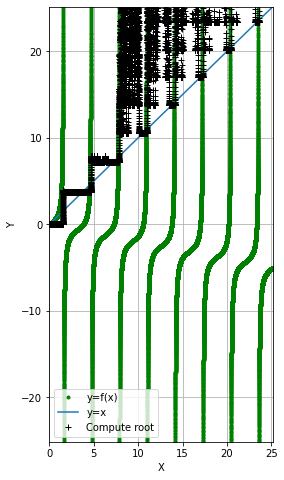

In [68]:
n = 1 << 16
k = 8
xmin, xmax = 0, k*np.pi
ymin, ymax = -k*np.pi, k*np.pi
tol = 1e-3
max_iters = 8
x0 = np.linspace(xmin, xmax, n)
root = newton_root_array(x0, tol, max_iters)
fig= plt.figure(figsize=(4,8))
plt.axis([xmin,xmax, ymin, ymax])
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(x0, -0.2*x0+np.tan(x0), 'g.', label='y=f(x)')
plt.plot(x0, 1.0*x0, label='y=x')
plt.plot(x0, root, 'k+', label='Compute root')
plt.legend()
plt.grid()
assert_approx_equal(root[1 << 14], 7.854, significant=3)

f) Select the conclusion that is best supported by your plot.

In [69]:
# uncomment a line below and evaluate to make your selection
answer = 'For each root, there is an interval of initial guesses for which Newtons method converges to the closest root.'
# answer = "Newton's method always converges to a value close to a root of the function f(x)."
# answer = "Newton's method always converges to the value of the root of the function f(x) closest to the initial guess."
# answer = "For each root, there is an interval of initial guesses for which Newton's method converges to the closest root."
# YOUR CODE HERE

In [70]:
assert_(answer != '')

g) The cell below repeats the essential code to compute roots for an array of initial guesses.

In [71]:
n = 1 << 16
k = 8
xmin = 0.
xmax = k*np.pi
x0 = np.linspace(xmin, xmax, n, dtype=np.float64)
tol = 1e-3
max_iters = 8
root = newton_root_array(x0, tol, max_iters)

Copy the code from the cell above, paste it into the cell below, modify it to measure the execution time, and assign your timing (in ms) to a variable named `serial_elapsed`.

In [72]:
from time import time
start = time()
n = 1 << 16
k = 8
xmin = 0.
xmax = k*np.pi
x0 = np.linspace(xmin, xmax, n, dtype=np.float64)
tol = 1e-3
max_iters = 8
root = newton_root_array(x0, tol, max_iters)
end = time()
serial_elapsed = (end - start)*1000

In [73]:
print("Serial elapsed time in ms: ", serial_elapsed)
assert_(serial_elapsed != None)

Serial elapsed time in ms:  2305.2263259887695


2. The goal of this problem is to create parallelized code for computing the array of Newton's method root estimates. Your implementation should include a function `parallel_newton_root_array` that calls a kernel function `newton_kernel` that calls a device function version of `newton_root`.

In [74]:
#The existing code for `newton_kernel` is below. Make appropriate adjustments to make it work as a device function.

import math 
from numba import cuda, jit, float32

PI = np.pi
TPB = 32

@cuda.jit(device = True)
def newton_root(x0, tol, max_iters):

    for _ in range(max_iters):
        if(abs(f(x0)) < tol):
            x = x0
            return x
        x = x0 -(f(x0)/df(x0))
        x0 = x
    return x


@cuda.jit(device = True)
def f(x):
    return -0.2*x + math.tan(x) 

@cuda.jit(device = True)
def df(x):
    return -0.2 + 1./(math.cos(x)**2)


@cuda.jit 
def newton_kernel(d_root, dx):
    i = cuda.grid(1)
    n = dx.shape[0]
    block = cuda.threadIdx.x
    if cuda.threadIdx.x == 1:
        print(block)
    if i < n :
        d_root[i] = newton_root(dx[i], tol, max_iters)

        
        
def parallel_newton_root_array(x0, tol, max_iters):

    n = x0.shape[0]
    dx = cuda.to_device(x0)
    d_root = cuda.device_array(n,dtype = np.float32)
    blockDims = TPB
    gridDims = (n+TPB-1)//TPB
    newton_kernel[gridDims, blockDims](d_root, dx)
    
    return d_root.copy_to_host()

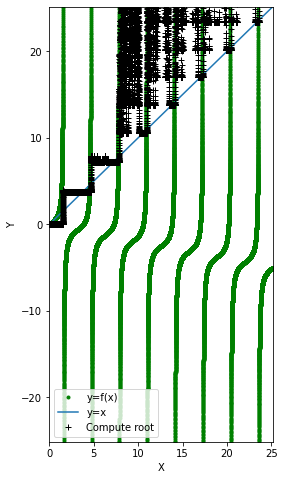

In [75]:
n = 1 << 16
k = 8
xmin, xmax = 0, k*np.pi
ymin, ymax = -k*np.pi, k*np.pi
tol = 1e-3
max_iters = 8
x0 = np.linspace(xmin, xmax, n)
parallel_root = parallel_newton_root_array(x0, tol, max_iters)
fig= plt.figure(figsize=(4,8))
plt.axis([xmin,xmax, ymin, ymax])
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(x0, -0.2*x0+np.tan(x0), 'g.', label='y=f(x)')
plt.plot(x0, 1.0*x0, label='y=x')
plt.plot(x0, parallel_root, 'k+', label='Compute root')
plt.legend()
assert_approx_equal(parallel_root[1 << 14], 7.854, significant=3)
assert_allclose(parallel_root, root, atol=1e-2)

Does the plot of your parallel results match up reasonably well with the plot of the serial results?

In [76]:
answer = 'Yes, the two plots are the same'

In [77]:
assert_(answer != None)

Does the plot of the parallel results support the same conclusion reached from the plot of the serial results above?

In [78]:
answer = 'Yes, since the plots are the same, we can draw same conclusion from the plot'

In [79]:
assert_(answer != None)

Does the `parallel_root` array match up with the `root` array? Propose an explanation for any differences you observe.

In [80]:
print(parallel_root[0:7])
print(root[0:7])
answer = 'They are the same'

[0.0000000e+00 3.8350106e-04 7.6700212e-04 1.1505032e-03 3.0081393e-09
 5.8752683e-09 1.0152457e-08]
[0.00000000e+00 3.83501049e-04 7.67002097e-04 1.15050315e-03
 3.00813925e-09 5.87526847e-09 1.01524565e-08]


3. Modify your parallel implementation to return both the `parallel_root` array and the time required for kernel execution using CUDA events. Also, have one thread in each block print the block number.

In [81]:
# insert modified code with CUDA event timing here

def parallel_newton_root_array(x0, tol, max_iters):
    start = cuda.event()
    end = cuda.event()
    
    tindex = cuda.threadIdx.x
    bindex = cuda.blockIdx.x
    n = x0.shape[0]
    dx = cuda.to_device(x0)
    d_root = cuda.device_array(n,dtype = np.float32)
    blockDims = TPB
    gridDims = (n+TPB-1)//TPB
    start.record()
    newton_kernel[gridDims, blockDims](d_root, dx)
    end.record()
    end.synchronize()
    
    kernel_duration = cuda.event_elapsed_time(start, end)
    print('Parallel Time is',kernel_duration)
    return d_root.copy_to_host(), kernel_duration

Execute your timed, parallel code, assign the kernel execution time (in ms) to the variable `parallel_elapsed`. The cell below assigns to the variable `speedup` the ratio of serial to parallel timings.

In [82]:
parallel_root, parallel_elapsed = parallel_newton_root_array(x0, tol, max_iters)
speedup = serial_elapsed/parallel_elapsed

Parallel Time is 3.1928319931030273


Execute your modified parallel code several time. Do the blocks execute in the same order? Answer YES or NO and briefly explain how you determined your answer.

In [83]:
answer = 'No. I used google colab and run the parallel codes several time. The colab shows different block each times.'
print('Speedup is', speedup)

Speedup is 722.0005095690557
